**Visualization of the data**

1. Set up phase

In [45]:
#Import of the needed libraries

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

In [46]:
def flatten_dict(d, parent_key='', sep='_'):
    items = {}
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.update(flatten_dict(v, new_key, sep=sep))
        else:
            items[new_key] = v
    return items

# Opening JSON file
f = open('port_arthur.json')
 
# returns JSON object as a dictionary
data = json.load(f)
 
# Flatten each dictionary and store the results in a list
flattened_dicts = [flatten_dict(d) for d in data['data']]

# Create a DataFrame
data = pd.DataFrame(flattened_dicts)
 
# Closing file
f.close()

In [47]:
#Modification of the variable naviguation_time in order to use it efficiently
data['navigation_time'] = pd.to_datetime(data['navigation_time'])

#Remove the duplicates
data = data.drop_duplicates()

data

,vessel_type,vessel_callsign,vessel_subtype,vessel_imo,vessel_name,navigation_draught,navigation_status,navigation_location_long,navigation_location_lat,navigation_speed,navigation_time,navigation_course,device_mmsi,device_dimensions_to_bow,device_dimensions_to_starboard,device_dimensions_to_stern,device_dimensions_to_port
0,tanker,EBZV,all,9236420,CATALUNYA SPIRIT,9.6,under-way-using-engine,-93.70755,29.41630,0.7,2021-04-07 16:01:55+00:00,45.9,224941000,226,24,58,19
1,tanker,EBZV,all,9236420,CATALUNYA SPIRIT,9.6,under-way-using-engine,-93.70643,29.41625,1.4,2021-04-07 16:06:15+00:00,118.6,224941000,226,24,58,19
2,tanker,EBZV,all,9236420,CATALUNYA SPIRIT,9.6,under-way-using-engine,-93.70459,29.41492,1.2,2021-04-07 16:11:05+00:00,144.9,224941000,226,24,58,19
4,tanker,EBZV,all,9236420,CATALUNYA SPIRIT,9.6,under-way-using-engine,-93.70219,29.41087,4.4,2021-04-07 16:21:54+00:00,97.0,224941000,226,24,58,19
5,tanker,EBZV,all,9236420,CATALUNYA SPIRIT,9.6,under-way-using-engine,-93.69435,29.41231,5.8,2021-04-07 16:26:44+00:00,62.8,224941000,226,24,58,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2342,cargo,9VAW8,all,9081801,HOSANGER,9.1,moored,-94.09057,30.07655,0.0,2021-04-08 08:11:46+00:00,277.5,563495000,187,16,26,15
2343,cargo,9VAW8,all,9081801,HOSANGER,9.1,moored,-94.09055,30.07655,0.0,2021-04-08 08:14:46+00:00,277.5,563495000,187,16,26,15
2344,cargo,9VAW8,all,9081801,HOSANGER,9.1,moored,-94.09057,30.07657,0.0,2021-04-08 08:20:45+00:00,277.5,563495000,187,16,26,15
2345,cargo,9VAW8,all,9081801,HOSANGER,9.1,moored,-94.09056,30.07656,0.0,2021-04-08 08:26:46+00:00,277.5,563495000,187,16,26,15


In [48]:
#Create a data frame only containing the tugs and another frame only containing the other vessels
tugs = data.loc[(data['vessel_type'] == 'tug')].reset_index()
non_tug = data.loc[(data['vessel_type'] != 'tug')].reset_index()

,index,vessel_type,vessel_callsign,vessel_subtype,vessel_imo,vessel_name,navigation_draught,navigation_status,navigation_location_long,navigation_location_lat,navigation_speed,navigation_time,navigation_course,device_mmsi,device_dimensions_to_bow,device_dimensions_to_starboard,device_dimensions_to_stern,device_dimensions_to_port
0,1388,tug,WDD7182,None,9397391,SABINE,4.0,under-way-using-engine,-93.96003,29.82966,0.0,2021-04-07 16:01:59+00:00,324.1,367182980,15,8,15,2
1,1389,tug,WDD7182,None,9397391,SABINE,4.0,under-way-using-engine,-93.96004,29.82965,0.0,2021-04-07 16:06:59+00:00,325.9,367182980,15,8,15,2
2,1390,tug,WDD7182,None,9397391,SABINE,4.0,under-way-using-engine,-93.96004,29.82964,0.0,2021-04-07 16:11:58+00:00,314.4,367182980,15,8,15,2
3,1391,tug,WDD7182,None,9397391,SABINE,4.0,under-way-using-engine,-93.96006,29.82963,0.0,2021-04-07 16:16:58+00:00,301.0,367182980,15,8,15,2
4,1392,tug,WDD7182,None,9397391,SABINE,4.0,under-way-using-engine,-93.96002,29.82963,0.0,2021-04-07 16:21:58+00:00,177.7,367182980,15,8,15,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,2144,tug,WDJ4094,regular,9812042,TRITON,6.0,under-way-using-engine,-93.93849,29.86099,0.0,2021-04-08 08:11:50+00:00,25.8,367774360,16,14,7,6
706,2145,tug,WDJ4094,regular,9812042,TRITON,6.0,under-way-using-engine,-93.93851,29.86098,0.0,2021-04-08 08:16:51+00:00,25.8,367774360,16,14,7,6
707,2146,tug,WDJ4094,regular,9812042,TRITON,6.0,under-way-using-engine,-93.93851,29.86099,0.0,2021-04-08 08:21:52+00:00,133.2,367774360,16,14,7,6
708,2147,tug,WDJ4094,regular,9812042,TRITON,6.0,under-way-using-engine,-93.93852,29.86098,0.0,2021-04-08 08:26:51+00:00,133.2,367774360,16,14,7,6


In [49]:
# Select the columns we want to keep
selected_columns = ['vessel_name','vessel_type', 'device_dimensions_to_bow', 'device_dimensions_to_starboard', 'device_dimensions_to_stern', 'device_dimensions_to_port']

# Create a new DataFrame with only the selected columns
new_data = data.loc[:, selected_columns]

# Group the data by 'vessel_name' and aggregate the values (first function)
aggregated_df = new_data.groupby('vessel_name').first().reset_index()

# Display the aggregated DataFrame
aggregated_df

,vessel_name,vessel_type,device_dimensions_to_bow,device_dimensions_to_starboard,device_dimensions_to_stern,device_dimensions_to_port
0,ALLIANCE NORFOLK,cargo,45,14,154,18
1,ATHENA,tug,10,12,6,12
2,BUCCANEER,tug,15,5,11,5
3,CARIBE LIZA,tanker,109,10,20,10
4,CATALUNYA SPIRIT,tanker,226,24,58,19
5,ENERGY PROGRESS,tanker,146,8,37,24
6,GAS GABRIELA,tanker,194,24,36,8
7,GASLOG GLASGOW,tanker,230,25,60,21
8,HOSANGER,cargo,187,16,26,15
9,IRELAND,cargo,196,23,33,10


2. Visualization of the data

In [50]:
# Define custom colors for each vessel type
custom_colors = ['mediumslateblue', 'goldenrod', 'darkgrey']

- Distribution of the vessel type within the data

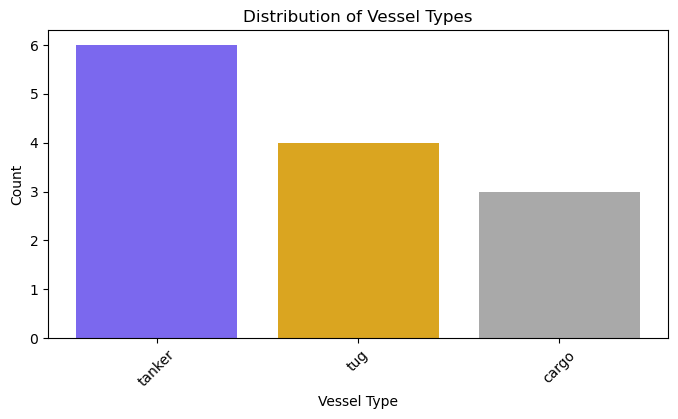

In [51]:
# Count the number of unique vessel types
vessel_type_counts = aggregated_df['vessel_type'].value_counts()

plt.figure(figsize=(8, 4))
plt.bar(vessel_type_counts.index, vessel_type_counts.values, color=custom_colors)
plt.xlabel('Vessel type')
plt.ylabel('Count')
plt.title('Distribution of vessel types')
plt.xticks(rotation=45)
plt.show()

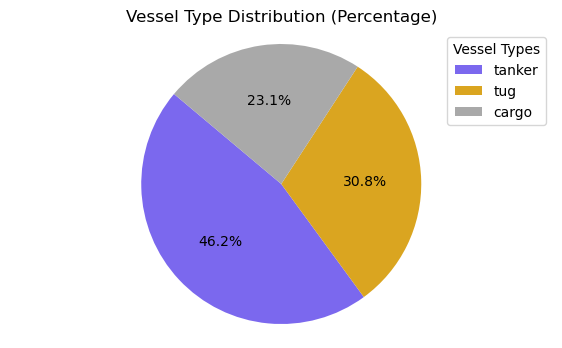

In [52]:
# Count the number of unique vessel types
vessel_type_counts = aggregated_df['vessel_type'].value_counts()

plt.figure(figsize=(7, 4))
plt.pie(vessel_type_counts, autopct='%1.1f%%', startangle=140, colors=custom_colors)
plt.title('Vessel type distribution (%)')

# Add a legend
plt.legend(vessel_type_counts.index, title='Vessel types', loc='best')
plt.axis('equal')  
plt.show()


- Box plots providing a visual summary of the distribution of the dimensions for all 3 different types of vessels

/Users/Sarah/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/Sarah/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/Sarah/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/Sarah/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/Sarah/opt/anaconda3/envs/CIEM6302/lib/python3

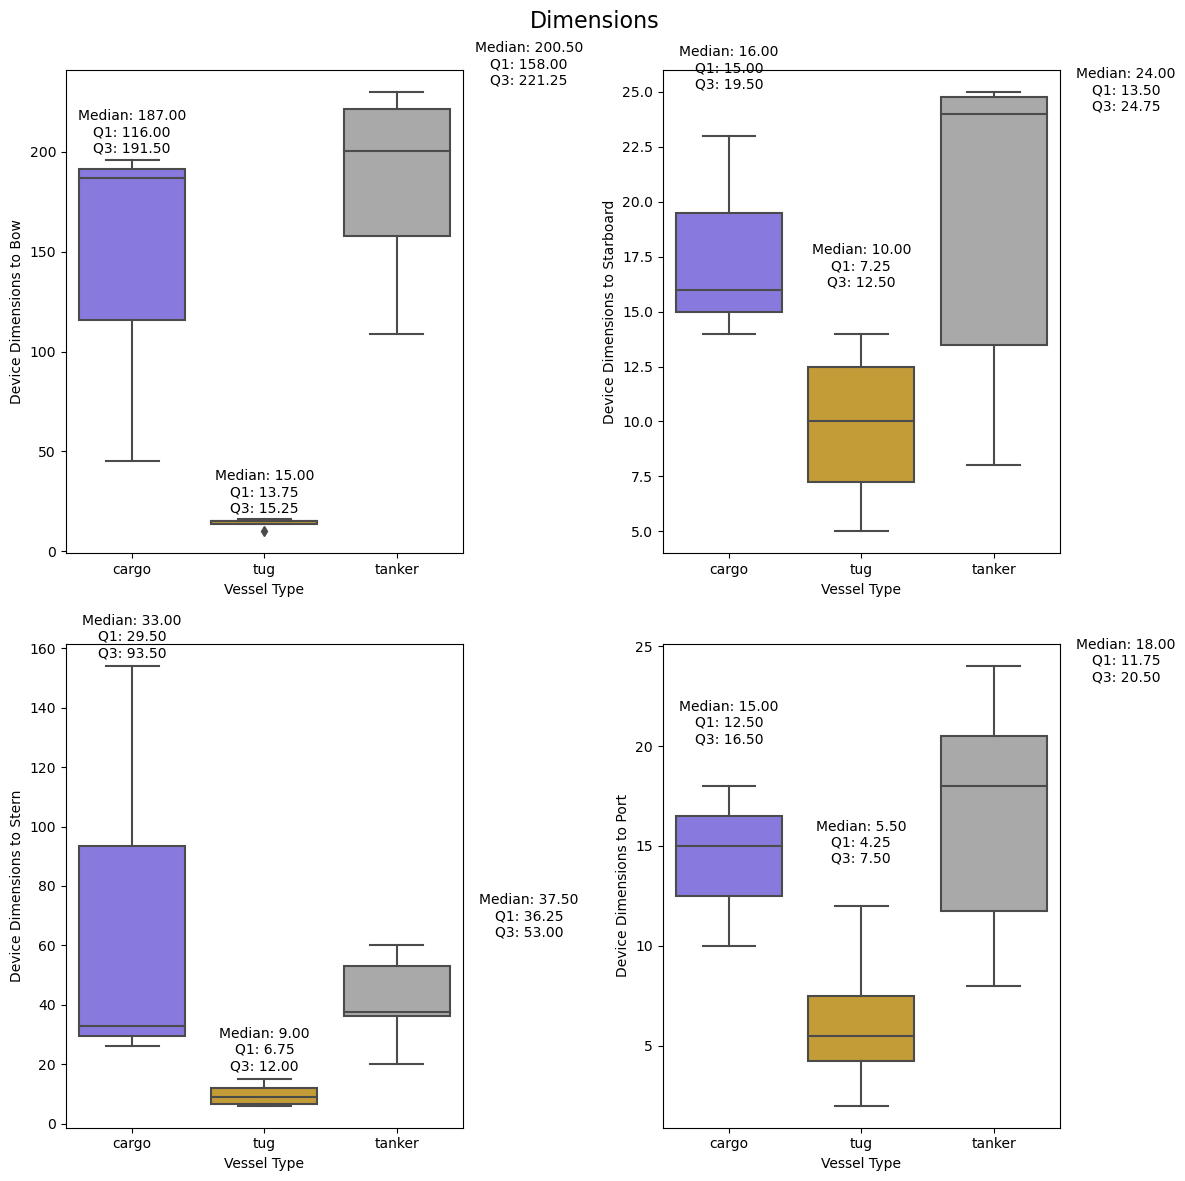

In [53]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# List of dimensions
dimensions = ['device_dimensions_to_bow', 'device_dimensions_to_starboard', 'device_dimensions_to_stern', 'device_dimensions_to_port']

# Iterate over dimensions and corresponding subplots
for dimension, ax in zip(dimensions, axes.flatten()):
    sns.boxplot(data=aggregated_df, x='vessel_type', y=dimension, palette=custom_colors, ax=ax)
    ax.set_xlabel('Vessel type')
    ax.set_ylabel(f'Device dimensions to {dimension.split("_")[-1].title()}')
    
    # Calculate and display statistical properties
    for vessel_type in aggregated_df['vessel_type'].unique():
        subset_data = aggregated_df[aggregated_df['vessel_type'] == vessel_type]
        median = subset_data[dimension].median()
        q1 = subset_data[dimension].quantile(0.25)
        q3 = subset_data[dimension].quantile(0.75)
        max_val = subset_data[dimension].max()
        
        # Determine the vertical position for labels
        text_y = max_val + 2 if max_val + 2 < ax.get_ylim()[1] else ax.get_ylim()[1] - 2
        
        ax.text(
            subset_data.index[0], 
            text_y, 
            f"Median: {median:.2f}\nQ1: {q1:.2f}\nQ3: {q3:.2f}", 
            horizontalalignment='center', 
            verticalalignment='bottom',
            color='black'
        )

# Set a single title for all subplots
fig.suptitle('Dimensions', fontsize=16)
plt.tight_layout()
plt.show()

- Heatmap to visualize the correlations between device dimensions

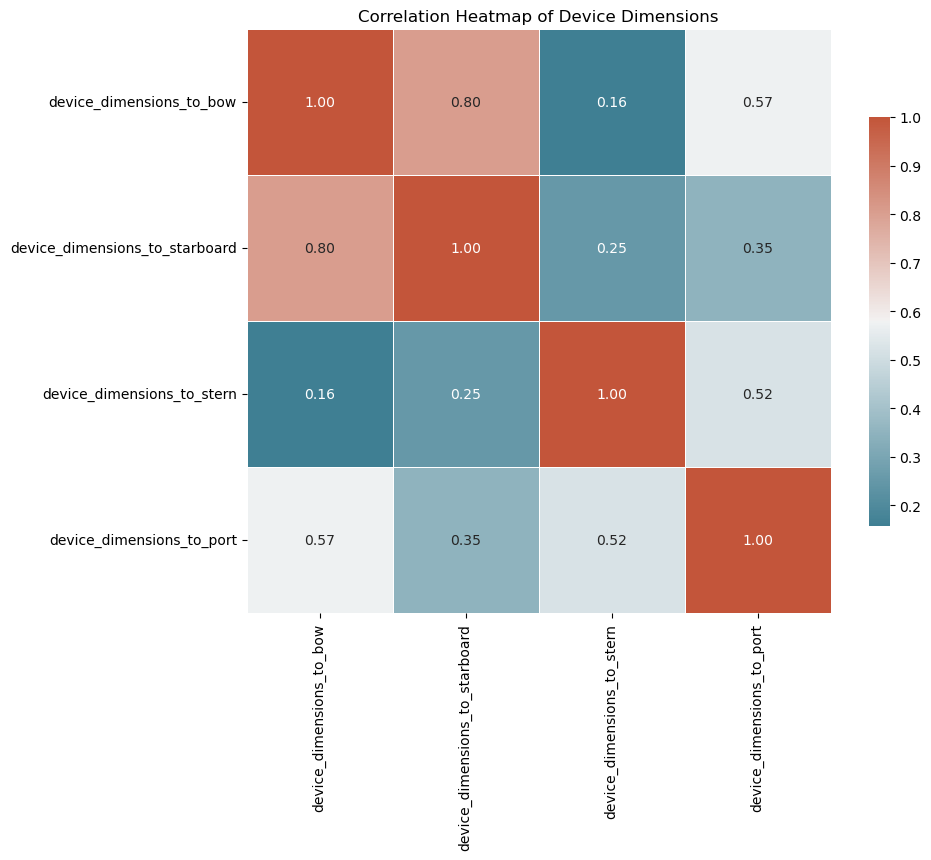

In [54]:

# List of device dimensions
device_dimensions = ['device_dimensions_to_bow', 'device_dimensions_to_starboard', 'device_dimensions_to_stern', 'device_dimensions_to_port']

correlation_matrix = aggregated_df[device_dimensions].corr()

# Create a figure with a larger size
plt.figure(figsize=(10, 8))


custom_cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Create the correlation heatmap with annotations
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.2f', 
    cmap=custom_cmap,
    linewidths=0.5,
    square=True,  
    cbar=True,  
    cbar_kws={'shrink': 0.7},  
)

plt.title('Correlation heatmap of device dimensions')
plt.subplots_adjust(bottom=0.15)
plt.show()

- Pair plot with device dimensions to visually explore and understand (with a grid of scatter plots, histograms and kernel density estimates (KDEs)) the relationships and distributions between different device dimensions within the dataset

/Users/Sarah/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/Sarah/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/Sarah/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/Sarah/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/Sarah/opt/anaconda3/envs/CIEM6302/lib/python3

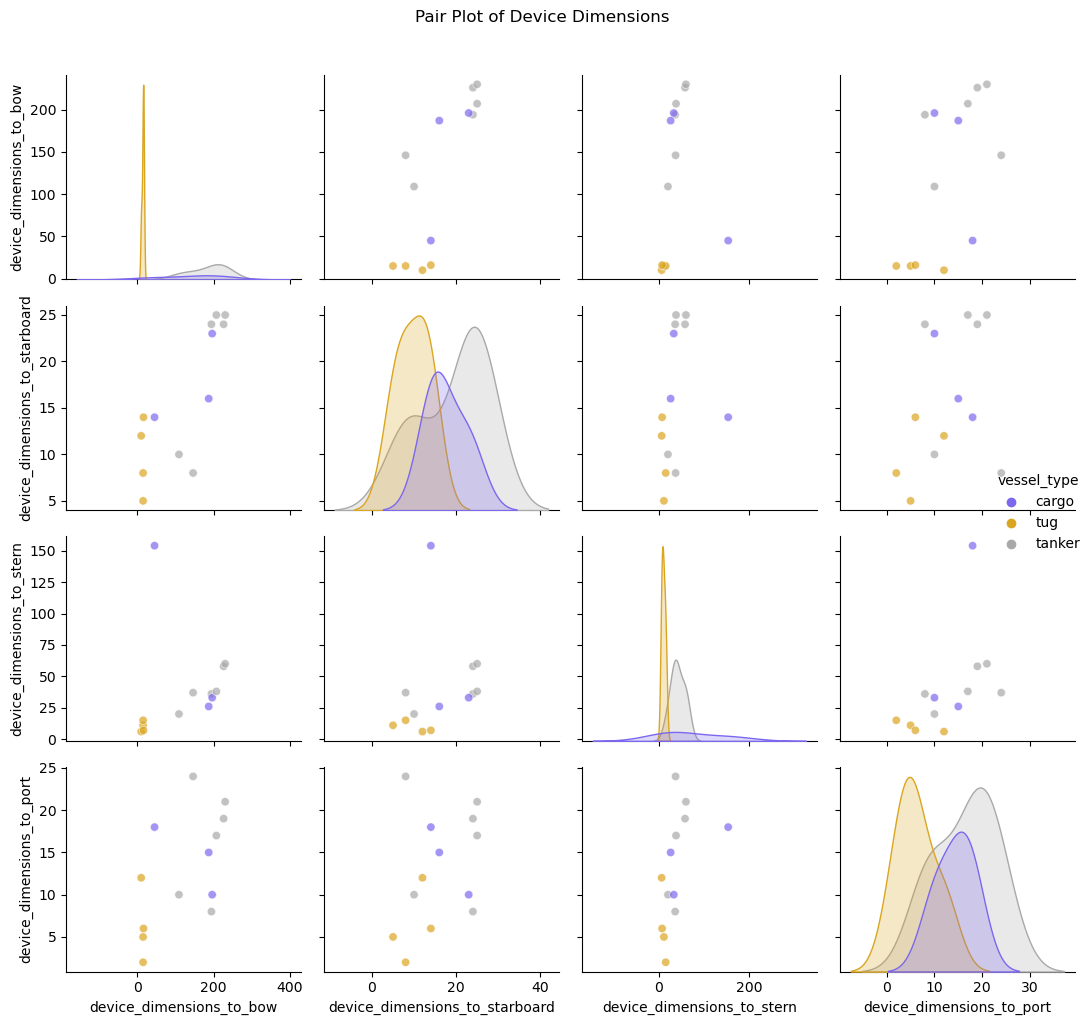

In [55]:
# List of device dimensions
device_dimensions = ['device_dimensions_to_bow', 'device_dimensions_to_starboard', 'device_dimensions_to_stern', 'device_dimensions_to_port']

# Create a pair plot
pairplot = sns.pairplot(
    data=aggregated_df,
    vars=device_dimensions,
    hue='vessel_type',  
    palette=custom_colors,  
    diag_kind='kde', 
    plot_kws={'alpha': 0.7}, 
    diag_kws={'shade': True},  
)

# Add a title to the pair plot
pairplot.fig.suptitle('Pair plot of device dimensions', y=1.02)
plt.tight_layout()
plt.show()

- Navigation speed over time for each tug

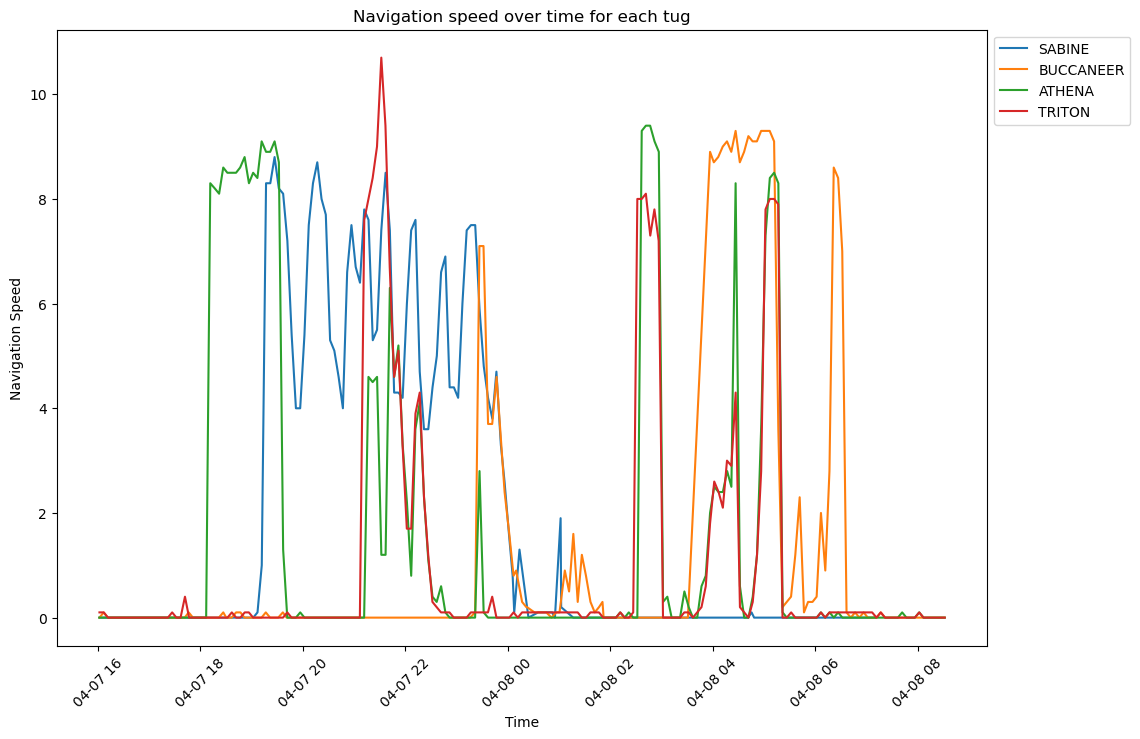

In [56]:
# Iterate through unique vessel names
unique_vessel_names = tugs['vessel_name'].unique()

plt.figure(figsize=(12, 8))

for vessel_name in unique_vessel_names:
    # Filter data for the current vessel name
    subset = tugs[tugs['vessel_name'] == vessel_name]
    
    # Create a line plot for navigation_speed over time for the current vessel
    plt.plot(subset['navigation_time'], subset['navigation_speed'], label=vessel_name)

# Set plot labels and title
plt.xlabel('Time')
plt.ylabel('Navigation speed')
plt.title('Navigation speed over time for each tug')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  
plt.show()

- Navigation speed over time for each tug, with the possibility here to get the values on the curves

In [ ]:
# Filter data for non-tug vessels
tug_data = data[data['vessel_type'] == 'tug']

# Create a figure
fig = go.Figure()

# Iterate through unique vessel names for non-tug vessels
unique_tug_names = tug_data['vessel_name'].unique()

for vessel_name in unique_tug_names:
    # Filter data for the current vessel name
    subset = tug_data[tug_data['vessel_name'] == vessel_name]
    
    # Create a line trace for navigation_speed over time for the current vessel
    fig.add_trace(go.Scatter(x=subset['navigation_time'], y=subset['navigation_speed'],
                             mode='lines+markers', name=vessel_name,
                             hoverinfo='x+y', text=subset['navigation_time'].dt.strftime('%Y-%m-%d %H:%M:%S')))

# Customize layout
fig.update_layout(
    title='Navigation speed over time for each tug',
    xaxis_title='Time',
    yaxis_title='Navigation speed',
    xaxis=dict(tickangle=-45),
    legend=dict(x=1, y=1)
)

# Show the plot
fig.show()

- Navigation speed over time for each vessel (non-tug)

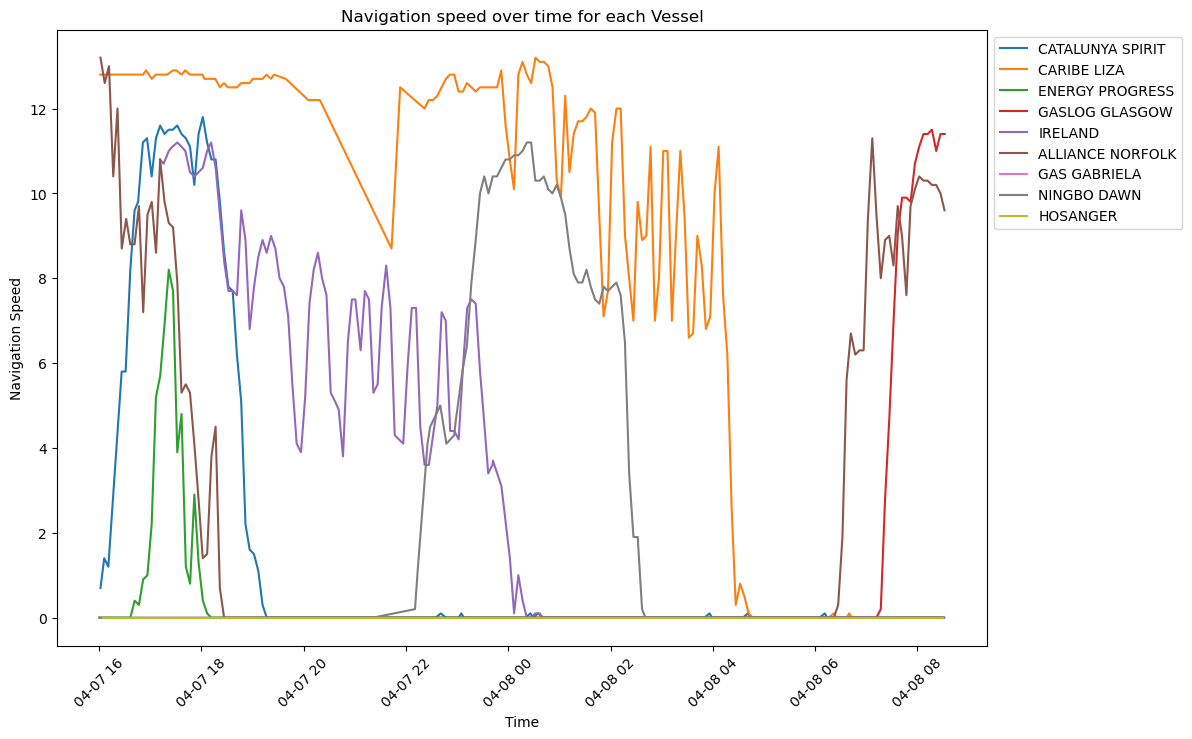

In [57]:
# Iterate through unique vessel names
unique_vessel_names = non_tug['vessel_name'].unique()

plt.figure(figsize=(12, 8))

for vessel_name in unique_vessel_names:
    # Filter data for the current vessel name
    subset = non_tug[non_tug['vessel_name'] == vessel_name]
    
    # Create a line plot for navigation_speed over time for the current vessel
    plt.plot(subset['navigation_time'], subset['navigation_speed'], label=vessel_name)

# Set plot labels and title
plt.xlabel('Time')
plt.ylabel('Navigation speed')
plt.title('Navigation speed over time for each vessel (non-tug vessels)')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Add legend outside the plot

plt.show()

- Navigation speed over time for each vessel (no tug), with the possibility here to get the values on the curves

In [58]:
# Filter data for non-tug vessels
non_tug_data = data[data['vessel_type'] != 'tug']

# Create a figure
fig = go.Figure()

# Iterate through unique vessel names for non-tug vessels
unique_vessel_names = non_tug_data['vessel_name'].unique()

for vessel_name in unique_vessel_names:
    # Filter data for the current vessel name
    subset = non_tug_data[non_tug_data['vessel_name'] == vessel_name]
    
    # Create a line trace for navigation_speed over time for the current vessel
    fig.add_trace(go.Scatter(x=subset['navigation_time'], y=subset['navigation_speed'],
                             mode='lines+markers', name=vessel_name,
                             hoverinfo='x+y', text=subset['navigation_time'].dt.strftime('%Y-%m-%d %H:%M:%S')))

# Customize layout
fig.update_layout(
    title='Navigation speed over time for each vessel (non-tug vessels)',
    xaxis_title='Time',
    yaxis_title='Navigation speed',
    xaxis=dict(tickangle=-45),
    legend=dict(x=1, y=1)
)

fig.show()


/Users/Sarah/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/Sarah/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/Sarah/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain

- Navigation speed over time for each vessel (tugs and non-tugs) separatly, possibility to choose the desired vessel in the top bar

In [60]:
# Create a Dash app
app = dash.Dash(__name__)

# Define the app layout
app.layout = html.Div([
    dcc.Dropdown(id='vessel-selector'),
    dcc.Graph(id='speed-function'),
])

# Create a color map to assign unique colors to vessels
vessel_colors = px.colors.qualitative.Set3

# Populate the dropdown menu with vessel names
vessel_dropdown = [{"label": vessel_name, "value": vessel_name} for vessel_name in data['vessel_name'].unique()]
@app.callback(
    Output('vessel-selector', 'options'),
    Input('vessel-selector', 'value')
)
def update_vessel_options(selected_vessel):
    return vessel_dropdown

# Define callback function to update speed function based on vessel selection
@app.callback(
    Output('speed-function', 'figure'),
    Input('vessel-selector', 'value')
)
def update_speed_function(selected_vessel_name):
    selected_vessel_data = data[data['vessel_name'] == selected_vessel_name]
    
    # Assign a unique color to the selected vessel based on the color map
    color_idx = data['vessel_name'].unique().tolist().index(selected_vessel_name)
    color = vessel_colors[color_idx % len(vessel_colors)]
    
    speed_function = go.Scatter(x=selected_vessel_data['navigation_time'], y=selected_vessel_data['navigation_speed'],
                                mode='lines+markers', hoverinfo='x+y',
                                text=selected_vessel_data['navigation_time'].dt.strftime('%Y-%m-%d %H:%M:%S'),
                                line=dict(color=color))
    
    updated_fig = make_subplots(rows=1, cols=1, subplot_titles=("Speed function",))
    updated_fig.add_trace(speed_function, row=1, col=1)
    updated_fig.update_layout(
        title_text=f'Speed function for {selected_vessel_name}',
        xaxis_title='Time',
        yaxis_title='Navigation speed',
        xaxis=dict(tickangle=-45),
    )
    
    return updated_fig

# Run the Dash app
if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)

- Pie charts of the navigation_status

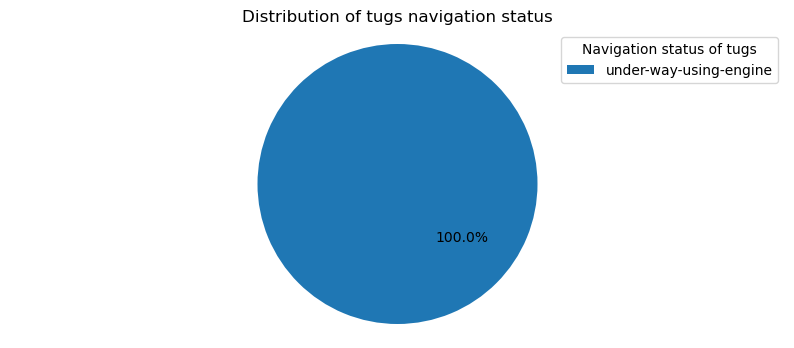

In [61]:
# Calculate the counts of each navigation status
navigation_status_counts = tugs['navigation_status'].value_counts()

plt.figure(figsize=(10, 4))

# Create the pie chart
plt.pie(navigation_status_counts, autopct='%1.1f%%', startangle=140)

# Add a legend with labels
plt.legend(navigation_status_counts.index, title='Navigation status of tugs', loc='upper right')

plt.title('Distribution of tugs navigation status')
plt.axis('equal')
plt.show()

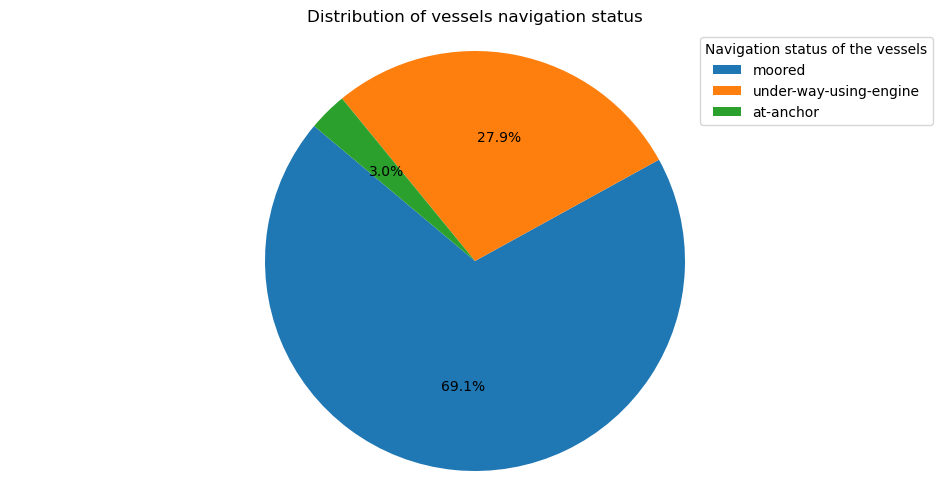

In [62]:
# Pie chart of navigation_status
# Calculate the counts of each navigation status
navigation_status_counts = non_tug['navigation_status'].value_counts()

plt.figure(figsize=(12, 6))

# Create the pie chart
plt.pie(navigation_status_counts, autopct='%1.1f%%', startangle=140)

# Add a legend with labels
plt.legend(navigation_status_counts.index, title='Navigation status of the vessels', loc='upper right')

plt.title('Distribution of vessels navigation status')
plt.axis('equal')
plt.show()

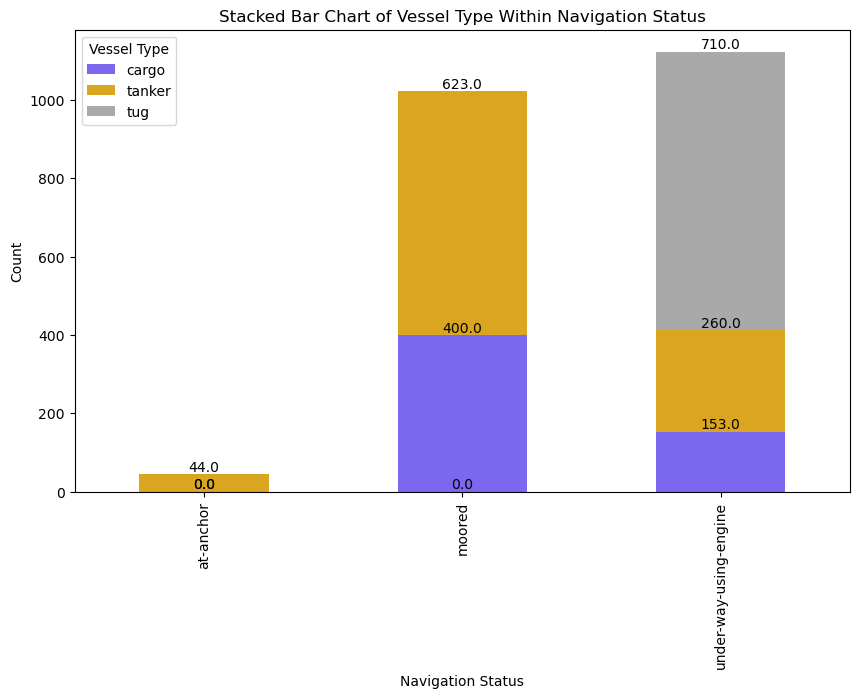

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
ValueError: None is not in list



/Users/Sarah/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [63]:
# Group data by 'navigation_status' and 'vessel_type' and count occurrences
status_type_counts = data.groupby(['navigation_status', 'vessel_type']).size().unstack(fill_value=0)

# Create a stacked bar chart with custom colors
ax = status_type_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=custom_colors)

# Add values on top of the bars
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10, color='black', labels=container.datavalues)

plt.xlabel('Navigation status')
plt.ylabel('Count')
plt.title('Stacked bar chart of vessel type within navigation status')

# Customize legend
ax.legend(title='Vessel Type', loc='upper left')

plt.show()
